In [1]:
import pandas as pd
df_ff_train = pd.read_csv("tep_faultfree_training.csv")
df_ff_test = pd.read_csv("tep_faultfree_testing.csv")
df_f_train = pd.read_csv("tep_faulty_training.csv")
df_f_test = pd.read_csv("tep_faulty_testing.csv")

df_ff_train["label"] = 0
df_f_train["label"] = 1
df_ff_test["label"] = 0
df_f_test["label"] = 1

df_train_combined = pd.concat(
    [df_ff_train, df_f_train],
    axis=0,          
    ignore_index=True
)

df_test_combined = pd.concat(
    [df_ff_test, df_f_test],
    axis=0,
    ignore_index=True
)

from sklearn.preprocessing import StandardScaler
import numpy as np

def scale_df(df, scaler):

    features_scaled = scaler.transform(df.iloc[:, :55])
    labels = df.iloc[:, 55:56].to_numpy().reshape(-1, 1)
    X_scaled = np.hstack([features_scaled, labels])
    df_scaled = pd.DataFrame(X_scaled, columns=df.columns, index=df.index)

    return df_scaled

scaler = StandardScaler()
scaler.fit(df_ff_train.iloc[:, :55])
df_ff_train = scale_df(df_ff_train, scaler)
df_test_combined = scale_df(df_test_combined, scaler)
df_train_combined = scale_df(df_train_combined, scaler)


## PCA setup - same as task 1

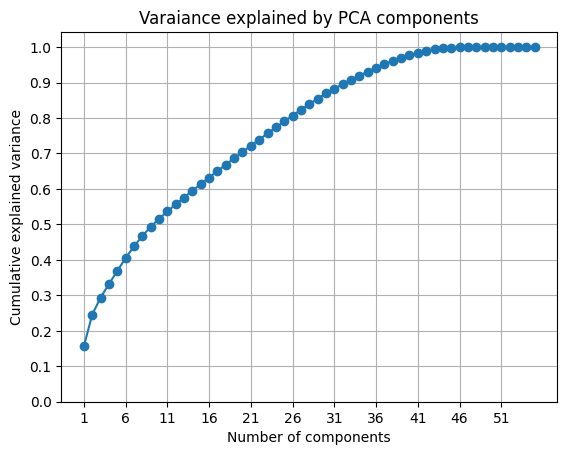

Explained variance by the first 10 components:
PC1: 15.59%
PC2: 8.92%
PC3: 4.83%
PC4: 3.79%
PC5: 3.73%
PC6: 3.63%
PC7: 3.29%
PC8: 2.93%
PC9: 2.59%
PC10: 2.23%


In [3]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

X_train = df_ff_train.iloc[:, :55].values
y_train = df_ff_train["label"].values

X_test = df_test_combined.iloc[:, :55].values
y_test = df_test_combined["label"].values

pca3 = PCA(n_components=55)
pca3.fit(X_train)

x = np.arange(1, len(pca3.explained_variance_ratio_[0:-1]) + 2)

plt.plot(x,np.cumsum(pca3.explained_variance_ratio_),marker='o')
plt.title('Varaiance explained by PCA components')
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.xticks(range(1, 56, 5))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.grid(True)
plt.show()

print("Explained variance by the first 10 components:")
for i in range(10):
    print(f"PC{i+1}: {pca3.explained_variance_ratio_[i]*100:.2f}%")


pca3 = PCA(n_components=21)
pca3.fit(X_train)

X_test_pca = pca3.transform(X_test)
X_train_pca = pca3.transform(X_train)

## KMeans clustering

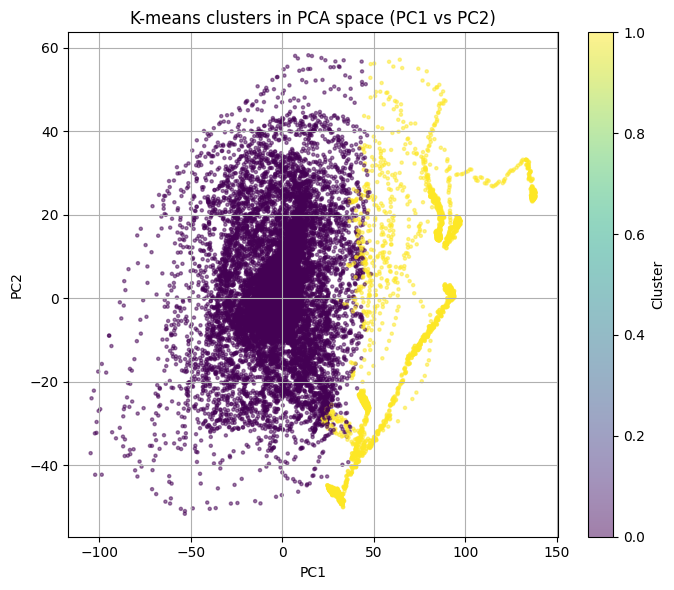

In [4]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

k = 2
kmeans = KMeans(n_clusters=k, random_state=69, n_init='auto').fit(X_test_pca)
cluster_test = kmeans.predict(X_test_pca)

plt.figure(figsize=(7, 6))

plt.scatter(
    X_test_pca[:, 0],
    X_test_pca[:, 1],
    c=cluster_test,     
    cmap='viridis',
    s=5,
    alpha=0.5
)

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("K-means clusters in PCA space (PC1 vs PC2)")
plt.colorbar(label="Cluster")
plt.grid(True)
plt.tight_layout()
plt.show()

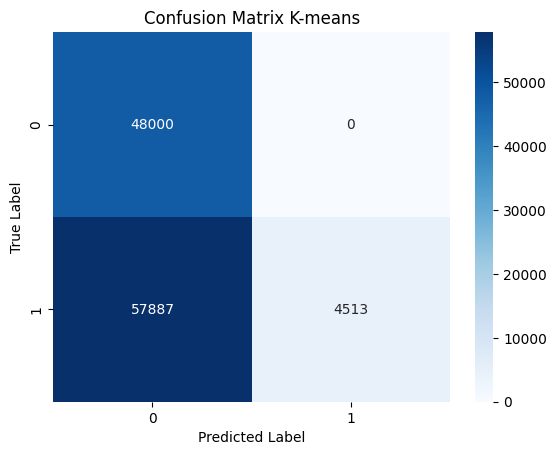

              precision    recall  f1-score   support

         0.0       0.45      1.00      0.62     48000
         1.0       1.00      0.07      0.13     62400

    accuracy                           0.48    110400
   macro avg       0.73      0.54      0.38    110400
weighted avg       0.76      0.48      0.35    110400



In [5]:
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

cf = confusion_matrix(y_test, cluster_test)
# Plot
sns.heatmap(cf, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix K-means")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

print(classification_report(y_test, cluster_test))

## DBSCAN

### KNN elbow

In [36]:
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

neighbors = NearestNeighbors(n_neighbors=21)
neighbors_fit = neighbors.fit(X_test_pca)
distances, indices = neighbors_fit.kneighbors(X_test_pca)
distances = np.sort(distances[:, -1])

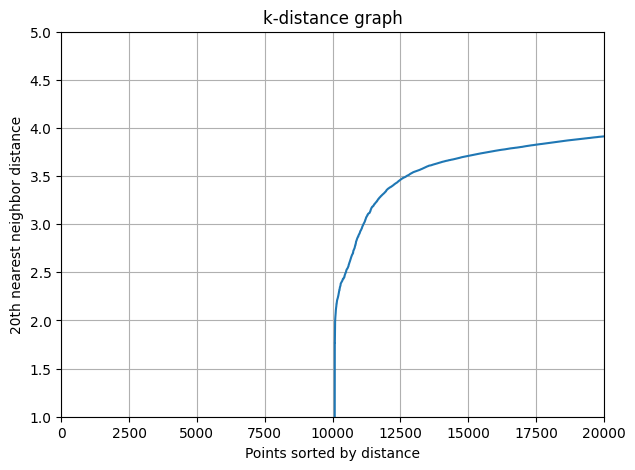

In [37]:
plt.figure(figsize=(7,5))
plt.plot(distances)
plt.title("k-distance graph")
plt.xlabel("Points sorted by distance")
plt.ylabel("20th nearest neighbor distance")
plt.xlim(00000, 20000)
plt.ylim(1, 5)
plt.grid(True)
plt.show()

## DBSCAN

In [45]:
from sklearn.cluster import DBSCAN
import json
from sklearn.metrics import confusion_matrix, accuracy_score

eps_values = np.linspace(2.2, 3.6, 10)
min_samples_list = range(20, 34, 2)

results = []  # store results for each eps
y_pred_list = []

for eps in eps_values:
        
    for min_samples in min_samples_list:
        db = DBSCAN(eps=eps, min_samples=min_samples, n_jobs=1, algorithm="brute").fit(X_test_pca)
        db_labels = db.labels_

        # Convert DBSCAN labels: outlier = -1 -> treat as faulty (1)
        y_pred = np.where(db_labels == -1, 1, 0)

        # Compute confusion matrix
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

        # Compute metrics
        precision = tp / (tp + fp + 1e-10)
        recall = tp / (tp + fn + 1e-10)
        f1 = 2 * precision * recall / (precision + recall + 1e-10)
        fnr = fn / (fn + tp + 1e-10)
        fpr = fp / (fp + tn + 1e-10)

        outliers = np.sum(db_labels == -1)
        ratio_outliers = outliers / (np.sum(y_test == 1) + 1e-10)

        accuracy = accuracy_score(y_test, y_pred)

        results.append({
            "eps": float(eps),
            "min_samples": int(min_samples),
            "precision": float(precision),
            "recall": float(recall),
            "f1": float(f1),
            "fnr": float(fnr),
            "fpr": float(fpr),
            "accuracy": float(accuracy),
            "outliers": int(outliers),
            "outlier_ratio": float(ratio_outliers),
            "y_pred": y_pred.tolist(),
            "db_labels": db_labels.tolist()
            })

with open("dbscan_results.json", "w") as f:
    json.dump(results, f, indent=4)


In [ ]:
db.fit_predict()

In [54]:
results_df = pd.read_json('dbscan_results.json')
top5 = results_df.sort_values(
    by=["f1", "recall", "precision"],
    ascending=False
).head(10)

top5.iloc[:,:10]

,eps,min_samples,precision,recall,f1,fnr,fpr,accuracy,outliers,outlier_ratio
6,2.200000,32,0.563792,0.993846,0.719452,0.006154,0.999625,0.561902,109998,1.762788
5,2.200000,30,0.563658,0.993285,0.719196,0.006715,0.999604,0.561594,109962,1.762212
4,2.200000,28,0.563488,0.992596,0.718876,0.007404,0.999604,0.561205,109919,1.761522
3,2.200000,26,0.563174,0.991330,0.718288,0.008670,0.999604,0.560489,109840,1.760256
2,2.200000,24,0.563077,0.990897,0.718096,0.009103,0.999562,0.560263,109811,1.759792
1,2.200000,22,0.562985,0.990529,0.717925,0.009471,0.999562,0.560054,109788,1.759423
13,2.355556,32,0.562543,0.988606,0.717060,0.011394,0.999417,0.559031,109661,1.757388
12,2.355556,30,0.562475,0.988333,0.716933,0.011667,0.999417,0.558877,109644,1.757115
11,2.355556,28,0.562363,0.987885,0.716724,0.012115,0.999417,0.558623,109616,1.756667
10,2.355556,26,0.562207,0.987260,0.716433,0.012740,0.999417,0.558270,109577,1.756042


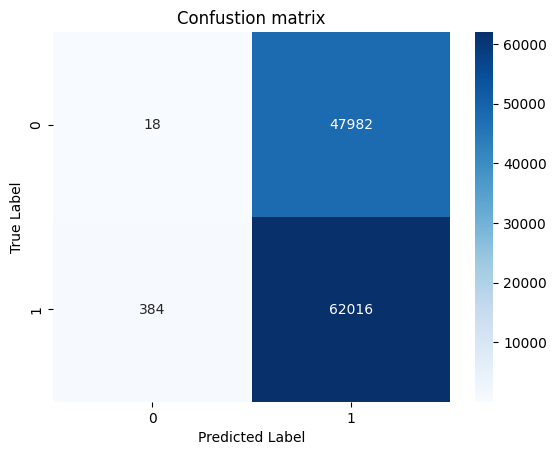

              precision    recall  f1-score   support

         0.0       0.04      0.00      0.00     48000
         1.0       0.56      0.99      0.72     62400

    accuracy                           0.56    110400
   macro avg       0.30      0.50      0.36    110400
weighted avg       0.34      0.56      0.41    110400



In [55]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = results_df.loc[6, "y_pred"]
cm2 = confusion_matrix(y_test, y_pred)
labels = results_df.loc[6,"db_labels"]

outliers = labels == -1
normal = labels != -1

sns.heatmap(cm2, annot=True, fmt='d', cmap='Blues')
plt.title("Confustion matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

print(classification_report(y_test, y_pred))


### PLots and stuff

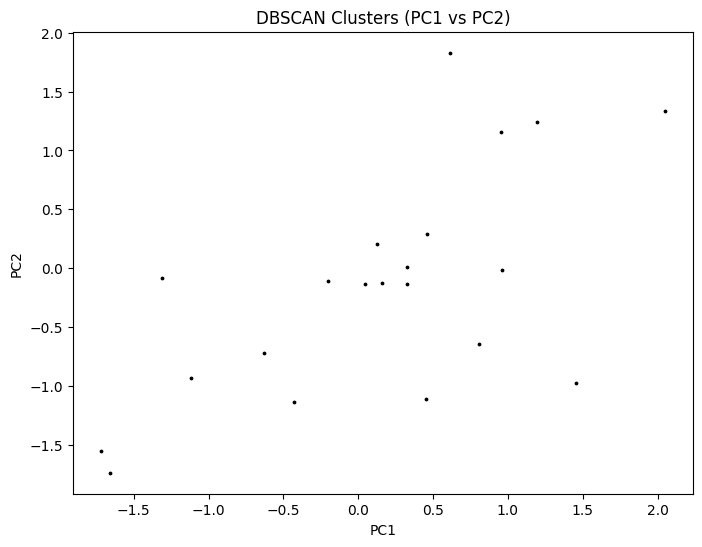

In [56]:
plt.figure(figsize=(8,6))
plt.scatter(
    X_test_pca[normal, 0],
    X_test_pca[normal, 1],
    c="black",
    s=3,
    label="Normal"
)

# Outliers i rött
plt.scatter(
    X_test_pca[outliers, 0],
    X_test_pca[outliers, 1],
    c="red",
    s=5,
    label="Fault / Outlier"
)
plt.title("DBSCAN Clusters (PC1 vs PC2)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


## HDBSCAN

In [ ]:
from sklearn.cluster import HDBSCAN
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

min_cluster_size_list = range(5, 50, 2)
min_samples_list = range(20, 40, 2)

results = [] 
y_pred_list = []

for min_cluster_size in min_cluster_size_list:
        
    for min_samples in min_samples_list:
        hdb = HDBSCAN(
            min_cluster_size=min_cluster_size,      
            min_samples=min_samples,           
            cluster_selection_epsilon=0.0
        )
        hdb_labels = hdb.fit_predict(X_test_pca)
        y_pred = np.where(hdb_labels == -1, 1, 0)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()


        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
        f1 = 2 * precision * recall / (precision + recall)
        fnr = fn / (fn + tp)
        fpr = fp / (fp + tn)

        outliers = np.sum(hdb_labels == -1)
        ratio_outliers = outliers / (np.sum(y_test == 1))

        accuracy = accuracy_score(y_test, y_pred)

        results.append({
            "min_cluster_size": int(min_cluster_size),
            "min_samples": int(min_samples),
            "precision": float(precision),
            "recall": float(recall),
            "f1": float(f1),
            "fnr": float(fnr),
            "fpr": float(fpr),
            "accuracy": float(accuracy),
            "outliers": int(outliers),
            "outlier_ratio": float(ratio_outliers),
            "y_pred": y_pred.tolist(),
            "hdb_labels": hdb_labels.tolist()
            })

with open("HDBscan_results.json", "w") as f:
    json.dump(results, f, indent=4)

In [ ]:
results

In [ ]:
outliers = df_test_combined["hdbscan"] == -1
faults   = df_test_combined["label"] == 1

print("Faults detected as outliers:", 
      np.mean(outliers[faults]) * 100, "%")

print("Normal detected as outliers:",
      np.mean(outliers[~faults]) * 100, "%")


plt.figure(figsize=(7,6))
plt.scatter(
      X_test_pca[:,0], X_test_pca[:,1],
      c=df_test_combined["hdbscan"],
      cmap='tab10', s=5, alpha=0.5
)
plt.title("HDBSCAN clustering in PCA space")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.grid(True)
plt.show()

labels = df_test_combined["hdbscan"]
colors = np.where(labels == -1, "black","red")

plt.figure(figsize=(7,6))
plt.scatter(X_test_pca[:,0], X_test_pca[:,1], c=colors, s=5, alpha=0.5)
plt.title("Outliers detected by HDBSCAN")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()